In [2]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.scores import *
from lib.models import *
from lib.cross_validation import *
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random


c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
# Defining some key variables that will be used later on in the training
DATASET = DatasetEnum.TwitterDataCleaned
DATASET_NAME = 'TwitterData'
MODEL_NAME = 'Bert'
CHECKPOINT_DIR = './checkpoints/' + DATASET_NAME + '/'
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
EPOCHS = 6
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET)
LABEL_COLS = train_df.columns[1:].tolist()
# scores dictionary
SCORES = {'accuracy': sl_accuracy,
          'f1_macro': sl_f1_macro,
          'f1_micro': sl_f1_micro}


### Cross Validation
we try to get the best parameters for a bert model on the datacleanedTwitter dataset

In [3]:
params_to_explore = {
    'learning_rate': [5e-05, 1e-04,1e-05],
    'regularization': [0, 1e-05],
    'batch_size': [8, 16],
    'epochs': [EPOCHS],
    'n_classes': [len(LABEL_COLS)],
}
RESULT_DIR = './results/' + DATASET_NAME + '/'
RESULT_FILE = RESULT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.csv'
# create the grid search object
grid_search = HoldOutCrossValidation(Bert, SCORES, train_df, val_df, param_dict=params_to_explore, res_file=RESULT_FILE)
# run the grid search
grid_search.run()

  0%|          | 0/12 [00:00<?, ?it/s]

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\gdema\Desktop\HLT\_project\HLT\lib\cross_validation.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat([self.results, pd.DataFrame([{**params, **train_scores, **val_scores}])], ignore_index=True)
c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when

In [4]:
# load the results
results = grid_search.get_results()
# get the best parameters and scores according to F1 macro
best_info = grid_search.get_best_info('f1_macro')
print("BEST MODEL INFO")
print(best_info)
# print the results
print("RESULTS")
print(results)
print("BEST PARAMS")
BEST_PARAMS = grid_search.get_best_params('f1_macro')
BEST_PARAMS['batch_size'] = int(BEST_PARAMS['batch_size'])
BEST_PARAMS['epochs'] = int(BEST_PARAMS['epochs'])
BEST_PARAMS['n_classes'] = int(BEST_PARAMS['n_classes'])
print(BEST_PARAMS)

BEST MODEL INFO
{'batch_size': 16, 'epochs': 6, 'learning_rate': 5e-05, 'n_classes': 6, 'regularization': 1e-05, 'train_accuracy': 0.959125, 'train_f1_macro': 0.9345971844504128, 'train_f1_micro': 0.959125, 'val_accuracy': 0.936, 'val_f1_macro': 0.9121271059411297, 'val_f1_micro': 0.936}
RESULTS
   batch_size epochs  learning_rate n_classes regularization  train_accuracy  \
0           8      6        0.00005         6              0        0.931813   
1          16      6        0.00005         6              0        0.938750   
2           8      6        0.00005         6        0.00001        0.936187   
3          16      6        0.00005         6        0.00001        0.959125   
4           8      6        0.00010         6              0        0.707375   
5          16      6        0.00010         6              0        0.909687   
6           8      6        0.00010         6        0.00001        0.324188   
7          16      6        0.00010         6        0.00001   

### datacleaned model
Now we can train a bert model with the best parameter and a fixed seed to reproduce the result and compare it with the uncleaned dataset

In [13]:
MINIBATCH_SIZE = 16
EPOCHS = 4
LAMBDA = 1e-05
LEARNING_RATE = 5e-05
train_df, val_df, test_df = load_dataset(DatasetEnum.TwitterDataCleaned)
MODEL_NAME = 'BertCleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':4, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':len(LABEL_COLS)}


SCORES = {'accuracy': sl_accuracy,
          'f1_macro': sl_f1_macro,
          'f1_micro': sl_f1_micro}

In [5]:

seed_val = 2
random.seed(seed_val)
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model = Bert(SCORES,
                PARAMS)    
model.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=False)


c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

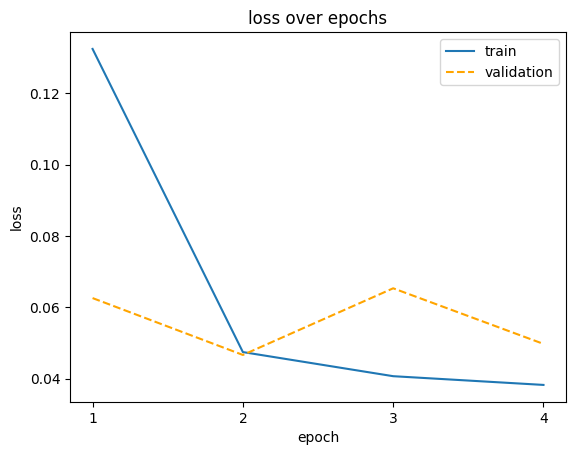

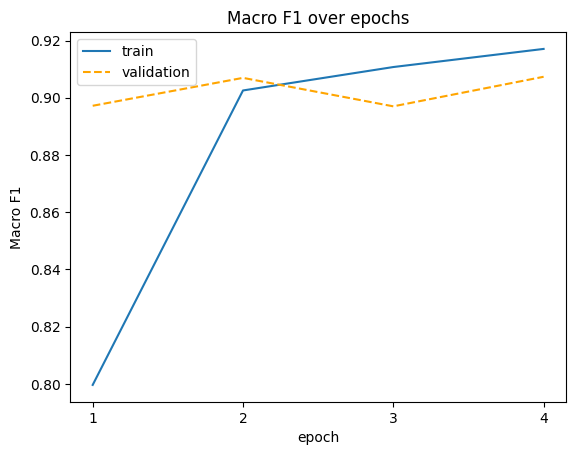

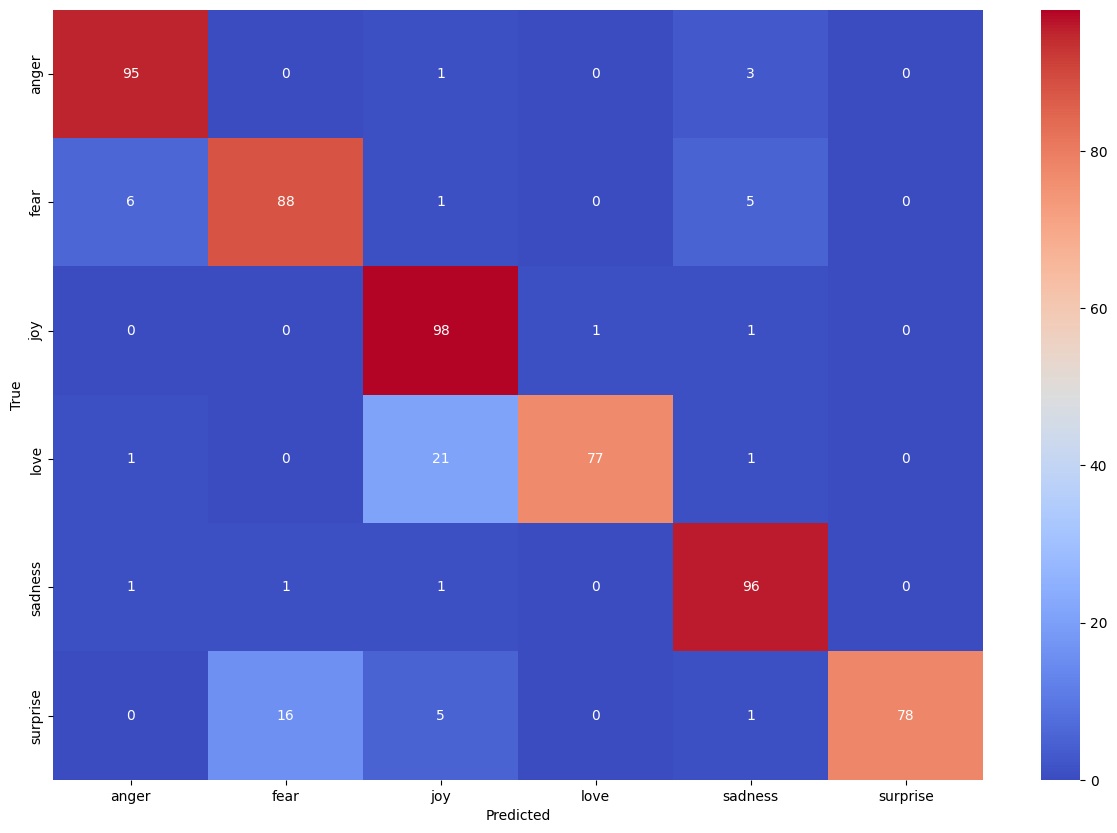

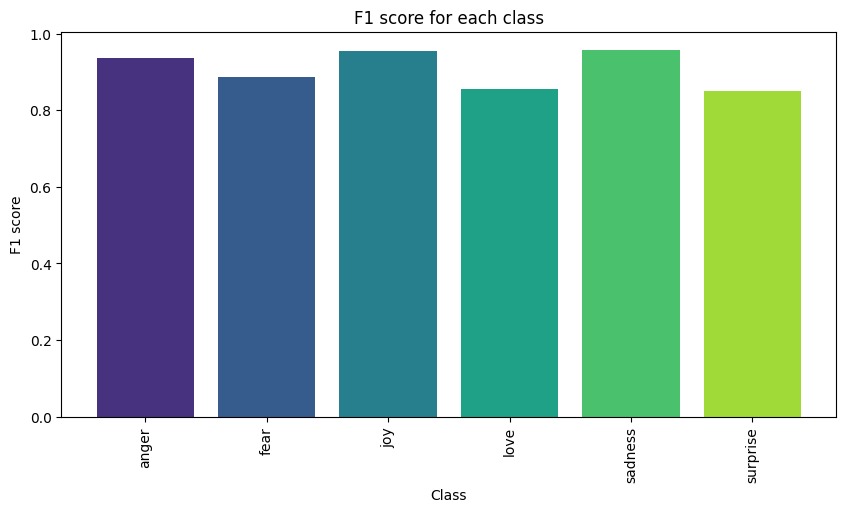

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.92                0.95                0.94                0.88                 275
fear                                0.89                0.88                0.89                0.79                 212
joy                                 0.93                0.98                0.96                0.92                 704
love                                0.96                0.77                0.86                0.75                 178
sadness                             0.95                0.96                0.96                0.92                 550
surprise                            0.94                0.78                0.85                0.74                  81
Macro avg                           0.93                0.89                0.91                0.83                2000
Micro avg

In [6]:
twitter_model_analysis(model, val_df, LABEL_COLS)

### Twitter:NoDataCleaning
We try to validate our datacleaning process training a bert model with vanilla tr-set

In [3]:
train_df, val_df, test_df = load_dataset(DatasetEnum.TwitterData, k_hot_encode=True)
MODEL_NAME = 'BertUncleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
MINIBATCH_SIZE = 16
EPOCHS = 4
LAMBDA = 1e-05
LEARNING_RATE = 5e-05
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':4, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':len(LABEL_COLS)}

SCORES = {'accuracy': sl_accuracy,
          'f1_macro': sl_f1_macro,
          'f1_micro': sl_f1_micro}

# creating the model with the same seed as the cleaned version
seed_val = 2
random.seed(seed_val)
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model_uncleaned = Bert(SCORES,
                PARAMS)    
model_uncleaned.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=False)

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

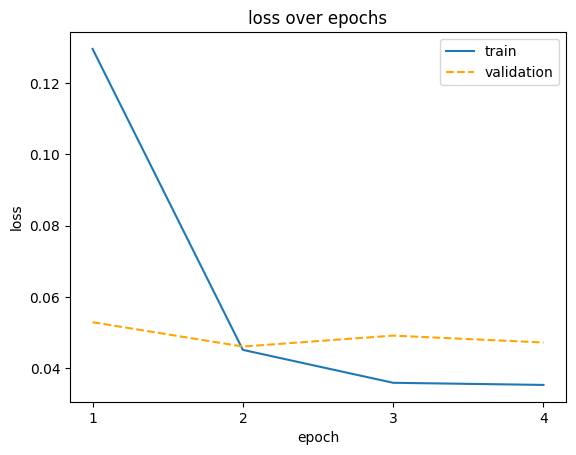

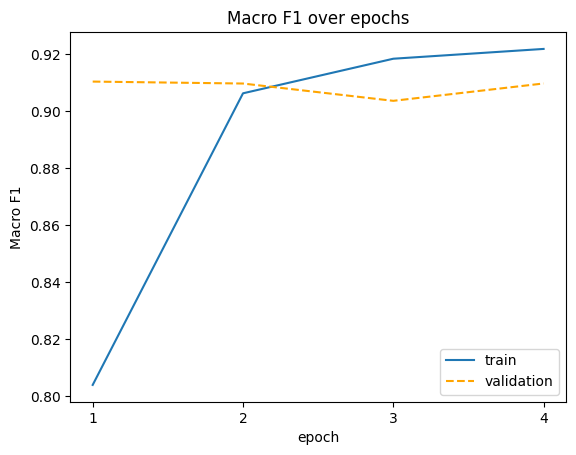

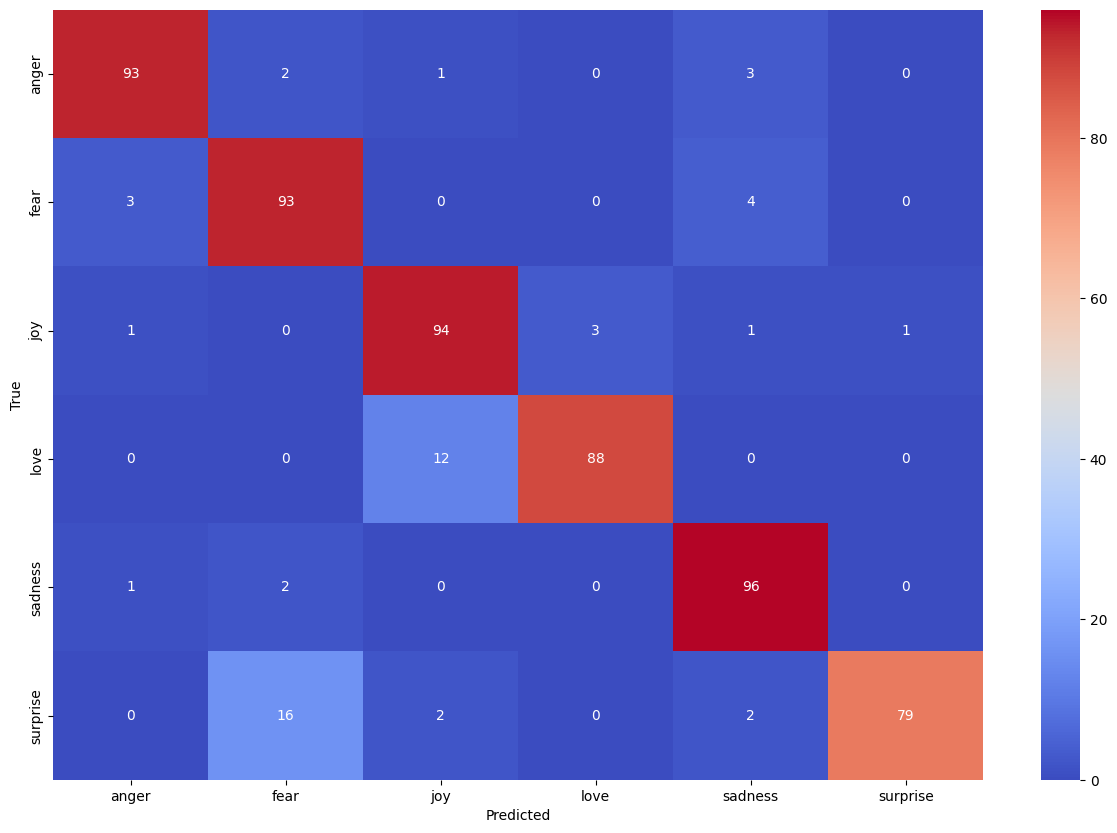

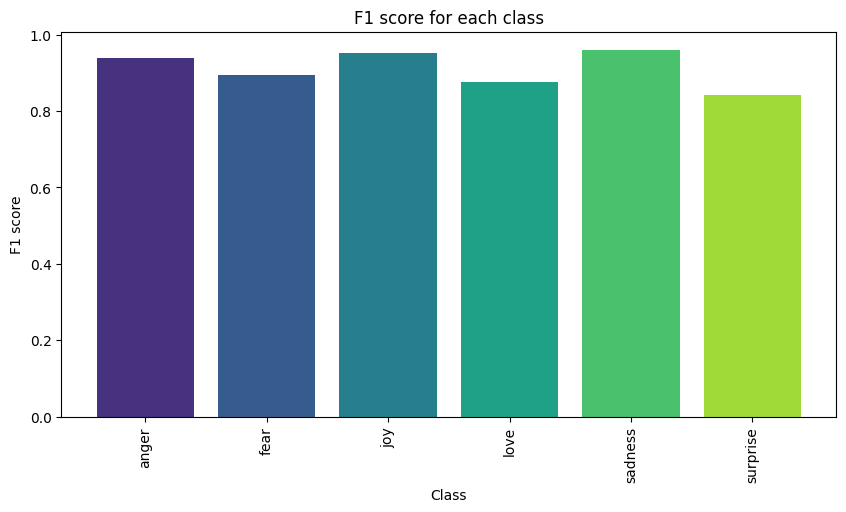

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.94                0.93                0.94                0.88                 275
fear                                0.86                0.93                0.89                0.81                 212
joy                                 0.96                0.94                0.95                0.91                 704
love                                0.87                0.88                0.88                0.78                 178
sadness                             0.96                0.96                0.96                0.92                 550
surprise                            0.90                0.79                0.84                0.73                  81
Macro avg                           0.92                0.91                0.91                0.84                2000
Micro avg

In [4]:
twitter_model_analysis(model_uncleaned, val_df, LABEL_COLS)

### Cleaned-Uncleaned comparison

In [14]:
_,val_df_uncleaned,_ = load_dataset(DatasetEnum.TwitterData, k_hot_encode=True)
_,val_df,_ = load_dataset(DatasetEnum.TwitterDataCleaned)
MODEL_NAME = 'BertCleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
model_cleaned = Bert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE)
MODEL_NAME = 'BertUncleaned'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
model_uncleaned = Bert(SCORES,
                PARAMS,checkpoint=CHECKPOINT_MODEL_FILE)


out_uncleaned = model_uncleaned.predict(val_df_uncleaned)
best_out_uncleaned = np.argmax(out_uncleaned, axis=1)
best_out_uncleaned = np.eye(len(LABEL_COLS))[best_out_uncleaned]
   
out_cleaned = model_cleaned.predict(val_df)
best_out_cleaned = np.argmax(out_cleaned, axis=1)
best_out_cleaned = np.eye(len(LABEL_COLS))[best_out_cleaned]

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


C:\Users\gdema\AppData\Local\Temp\ipykernel_17760\2379376959.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(),


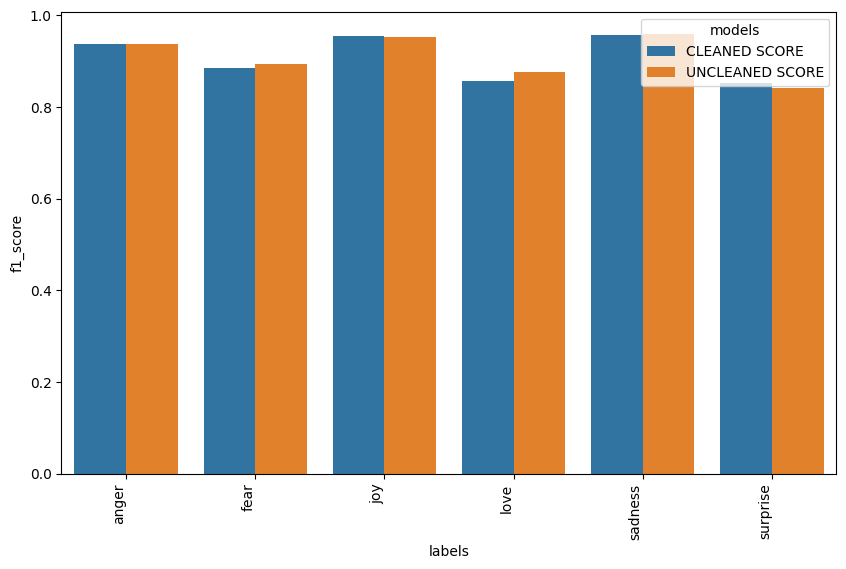

cleaned mean = 0.9073311185612812
uncleaned mean = 0.9104609148867101


In [15]:
target = val_df[LABEL_COLS].values
cleaned_score = f1_score(target, best_out_cleaned,average=None)
uncleaned_score = f1_score(target, best_out_uncleaned,average=None)

# we create a dataframe with for each label the f1 score for both the models
results_df=pd.DataFrame(zip(LABEL_COLS,cleaned_score,uncleaned_score),columns=["labels","CLEANED SCORE","UNCLEANED SCORE"])
results_df = pd.melt(results_df, id_vars="labels", var_name="models", value_name="f1_score")
plt.figure(figsize=(10, 6))
barplot=sns.barplot(x="labels", hue="models", y="f1_score", data=results_df)
barplot.set_xticklabels(barplot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()

print(f"cleaned mean = {np.mean(cleaned_score)}\nuncleaned mean = {np.mean(uncleaned_score)}")

## Finale model
Now we can priduce the final model using uncleaned dataset with random seed


In [16]:
train_df, val_df, test_df = load_dataset(DatasetEnum.TwitterData, k_hot_encode=True)
MODEL_NAME = 'Bert'
CHECKPOINT_MODEL_FILE = CHECKPOINT_DIR + DATASET_NAME + '_' + MODEL_NAME + '.pth'
MINIBATCH_SIZE = 16
EPOCHS = 4
LAMBDA = 1e-05
LEARNING_RATE = 5e-05
PARAMS = {'batch_size':MINIBATCH_SIZE, 
          'learning_rate':LEARNING_RATE, 
          'epochs':4, 
          'loss_function':loss_function, 
          'regularization':LAMBDA,
          'n_classes':len(LABEL_COLS)}

SCORES = {'accuracy': sl_accuracy,
          'f1_macro': sl_f1_macro,
          'f1_micro': sl_f1_micro}


model_uncleaned = Bert(SCORES, PARAMS)    
model_uncleaned.fit(train_df, validation_df=val_df, progress_bar_epoch=True, progress_bar_step=True, checkpoint_path=CHECKPOINT_MODEL_FILE,checkpoint_score="f1_macro",checkpoint_score_maximize=True,shuffle_training=True)

c:\Users\gdema\Anaconda3\envs\hlt_projevct\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

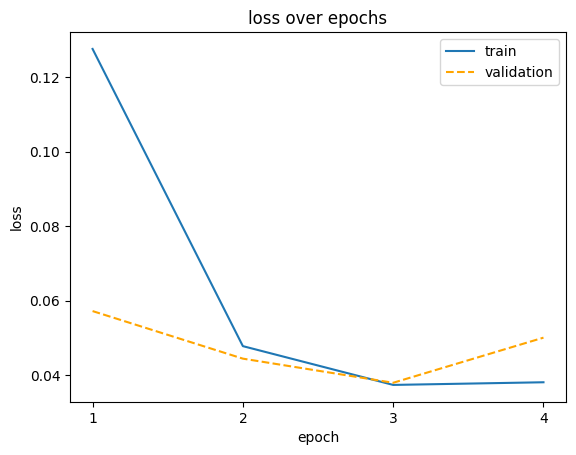

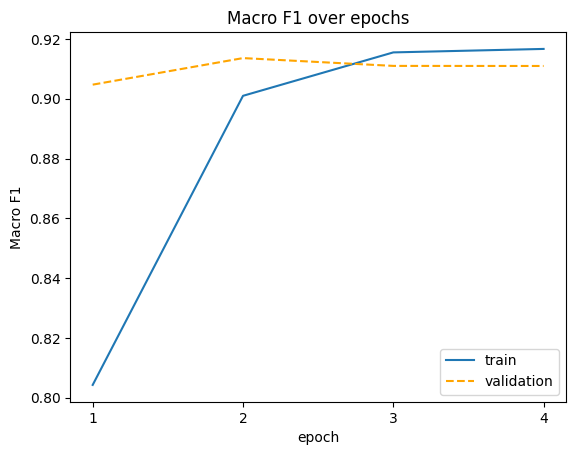

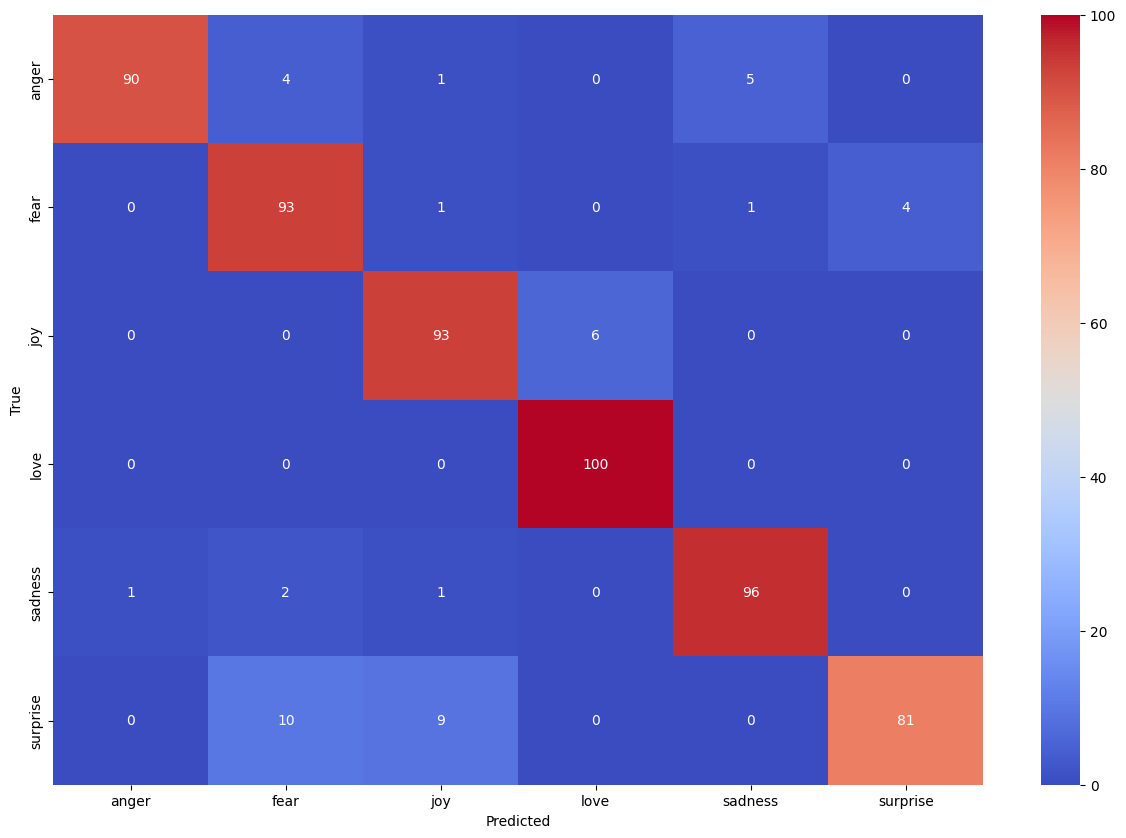

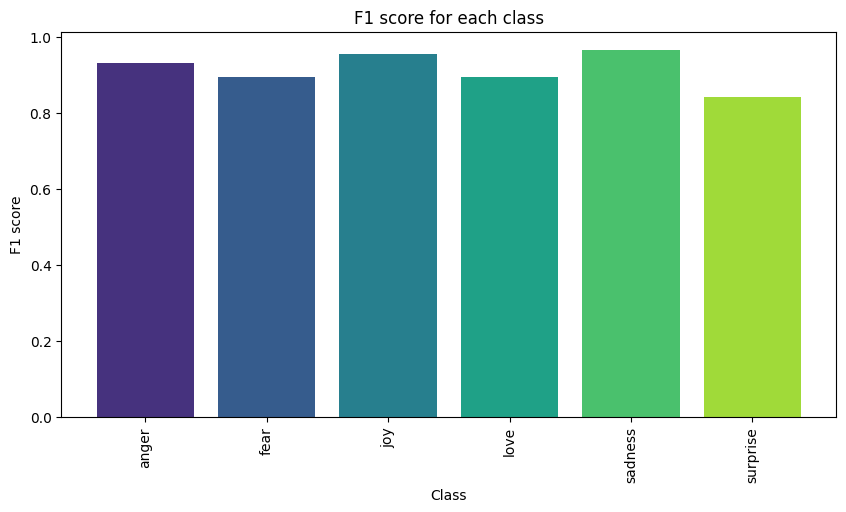

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.97                0.90                0.93                0.87                 275
fear                                0.86                0.93                0.89                0.81                 212
joy                                 0.98                0.93                0.95                0.91                 704
love                                0.81                1.00                0.89                0.81                 178
sadness                             0.97                0.96                0.97                0.93                 550
surprise                            0.87                0.81                0.84                0.73                  81
Macro avg                           0.91                0.92                0.91                0.84                2000
Micro avg

In [17]:
twitter_model_analysis(model_uncleaned, val_df, LABEL_COLS)